In [1]:
import time
import os
import random
import numpy as np                                                
import matplotlib.pyplot as plt                                   
import autograd, autograd.core, autograd.extend, autograd.tracer  
import autograd.numpy as anp      
import scipy, scipy.ndimage, scipy.sparse, scipy.sparse.linalg    
                                                     
import gym
# from gym import spaces
from gymnasium import spaces
import gymnasium 

from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import results_plotter

In [2]:
# !pip3 install --upgrade stable_baselines3
# !pip3 install gym==0.22.0 

The below code is my RL extension to and rework of https://www.researchgate.net/publication/360698153_A_Tutorial_on_Structural_Optimization 
and
https://www.sciencedirect.com/science/article/pii/S0264127522002933

In [3]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
    
def get_args(normals, forces, density=1e-4):  # Manage the problem setup parameters
    width = normals.shape[0] - 1
    height = normals.shape[1] - 1
    fixdofs = np.flatnonzero(normals.ravel())
    alldofs = np.arange(2 * (width + 1) * (height + 1))
    freedofs = np.sort(list(set(alldofs) - set(fixdofs)))
    params = {
      # material properties
      'young': 1, 'young_min': 1e-9, 'poisson': 0.3, 'g': 0,
      # constraints
      'density': density, 'xmin': 0.001, 'xmax': 1.0,
      # input parameters
      'nelx': width, 'nely': height, 'mask': 1, 'penal': 3.0, 'filter_width': 1,
      'freedofs': freedofs, 'fixdofs': fixdofs, 'forces': forces.ravel(),
      # optimization parameters
      'opt_steps': 80, 'print_every': 10}
    return ObjectView(params)

def mbb_beam(width=4, height=4, density=1e-4, y=1, x=0, rd=-1):  # textbook beam example
    normals = np.zeros((width + 1, height + 1, 2))
    normals[0, 0, x] = 1
    normals[0, 0, y] = 1
    normals[0, -1, x] = 1
    normals[0, -1, y] = 1
    forces = np.zeros((width + 1, height + 1, 2))
    forces[-1, rd, y] = -1
    return normals, forces, density

In [4]:
def young_modulus(x, e_0, e_min, p=3):
    return e_min + x ** p * (e_0 - e_min)

def physical_density(x, args, volume_contraint=False, use_filter=True):
    x = args.mask * x.reshape(args.nely, args.nelx)  # reshape from 1D to 2D
    return gaussian_filter(x, args.filter_width) if use_filter else x  # maybe filter

def mean_density(x, args, volume_contraint=False, use_filter=True):
    return anp.mean(physical_density(x, args, volume_contraint, use_filter)) / anp.mean(args.mask)

In [5]:
def objective(x, args, volume_contraint=False, use_filter=True):
    kwargs = dict(penal=args.penal, e_min=args.young_min, e_0=args.young)
    x_phys = physical_density(x, args, volume_contraint=volume_contraint, use_filter=use_filter)
    ke     = get_stiffness_matrix(args.young, args.poisson)  # stiffness matrix
    u      = displace(x_phys, ke, args.forces, args.freedofs, args.fixdofs, **kwargs)
    c      = compliance(x_phys, u, ke, **kwargs)
    return c

In [6]:
@autograd.extend.primitive
def gaussian_filter(x, width): # 2D gaussian blur/filter
    return scipy.ndimage.gaussian_filter(x, width, mode='reflect')

def _gaussian_filter_vjp(ans, x, width): # gives the gradient of orig. function w.r.t. x
    del ans, x  # unused
    return lambda g: gaussian_filter(g, width)
autograd.extend.defvjp(gaussian_filter, _gaussian_filter_vjp)

In [7]:
def compliance(x_phys, u, ke, *, penal=3, e_min=1e-9, e_0=1):
    nely, nelx = x_phys.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords for the index map

    n1 = (nely+1)*(elx+0) + (ely+0)  # nodes
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    all_ixs = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    u_selected = u[all_ixs]  # select from u matrix

    ke_u = anp.einsum('ij,jkl->ikl', ke, u_selected)  # compute x^penal * U.T @ ke @ U
    ce = anp.einsum('ijk,ijk->jk', u_selected, ke_u)
    C = young_modulus(x_phys, e_0, e_min, p=penal) * ce.T
    return anp.sum(C)

def get_stiffness_matrix(e, nu):  # e=young's modulus, nu=poisson coefficient
    k = anp.array([1/2-nu/6, 1/8+nu/8, -1/4-nu/12, -1/8+3*nu/8,
                -1/4+nu/12, -1/8-nu/8, nu/6, 1/8-3*nu/8])
    return e/(1-nu**2)*anp.array([[k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
                               [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
                               [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
                               [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
                               [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
                               [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
                               [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
                               [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]]])

In [8]:
def get_k(stiffness, ke):
    # Constructs sparse stiffness matrix k (used in the displace fn)
    # First, get position of the nodes of each element in the stiffness matrix
    nely, nelx = stiffness.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords
    ely, elx = ely.reshape(-1, 1), elx.reshape(-1, 1)

    n1 = (nely+1)*(elx+0) + (ely+0)
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    edof = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    edof = edof.T[0]
    x_list = anp.repeat(edof, 8)  # flat list pointer of each node in an element
    y_list = anp.tile(edof, 8).flatten()  # flat list pointer of each node in elem

    # make the global stiffness matrix K
    kd = stiffness.T.reshape(nelx*nely, 1, 1)
    value_list = (kd * anp.tile(ke, kd.shape)).flatten()
    return value_list, y_list, x_list

def displace(x_phys, ke, forces, freedofs, fixdofs, *, penal=3, e_min=1e-9, e_0=1):
    # Displaces the load x using finite element techniques (solve_coo=most of runtime)
    stiffness = young_modulus(x_phys, e_0, e_min, p=penal)
    k_entries, k_ylist, k_xlist = get_k(stiffness, ke)

    index_map, keep, indices = _get_dof_indices(freedofs, fixdofs, k_ylist, k_xlist)

    u_nonzero = solve_coo(k_entries[keep], indices, forces[freedofs], sym_pos=True)
    u_values = anp.concatenate([u_nonzero, anp.zeros(len(fixdofs))])
    return u_values[index_map]

In [9]:
def _get_dof_indices(freedofs, fixdofs, k_xlist, k_ylist):
    index_map = inverse_permutation(anp.concatenate([freedofs, fixdofs]))
    keep = anp.isin(k_xlist, freedofs) & anp.isin(k_ylist, freedofs)
    # Now we index an indexing array that is being indexed by the indices of k
    i = index_map[k_ylist][keep]
    j = index_map[k_xlist][keep]
    return index_map, keep, anp.stack([i, j])

def inverse_permutation(indices):  # reverses an index operation
    inverse_perm = np.zeros(len(indices), dtype=anp.int64)
    inverse_perm[indices] = np.arange(len(indices), dtype=anp.int64)
    return inverse_perm

In [10]:
def _get_solver(a_entries, a_indices, size, sym_pos):
    # a is (usu.) symmetric positive; could solve 2x faster w/sksparse.cholmod.cholesky(a).solve_A
    a = scipy.sparse.coo_matrix((a_entries, a_indices), shape=(size,)*2).tocsc()
    return scipy.sparse.linalg.splu(a).solve

@autograd.primitive
def solve_coo(a_entries, a_indices, b, sym_pos=False):
    solver = _get_solver(a_entries, a_indices, b.size, sym_pos)
    return solver(b)

def grad_solve_coo_entries(ans, a_entries, a_indices, b, sym_pos=False):
    def jvp(grad_ans):
        lambda_ = solve_coo(a_entries, a_indices if sym_pos else a_indices[::-1],
                            grad_ans, sym_pos)
        i, j = a_indices
        return -lambda_[i] * ans[j]
    return jvp

autograd.extend.defvjp(solve_coo, grad_solve_coo_entries,
                       lambda: print('err: gradient undefined'),
                       lambda: print('err: gradient not implemented'))

In [11]:
class Model:
    def __init__(self, x):
        self.flag_ = True
#         self.flag_ = False
        self.n, self.m = x.shape
        self.actions_dic={} 
    
        k=0
        for i in range(self.n):
            for j in range(self.m):
                self.actions_dic[k]=(i,j)
                k+=1
        
    def action_space_(self, action, X):
        x,y=self.actions_dic[action]
        X[x][y]=1
        
    def draw(self,X):  
        plt.figure(dpi=50) 
        print('\nFinal Cantilever beam design:')
        plt.imshow(X) 
        plt.show()

In [12]:
def fast_stopt(args, x):

    reshape = lambda x: x.reshape(args.nely, args.nelx)
    objective_fn = lambda x: objective(reshape(x), args)
#     constraint = lambda params: mean_density(reshape(params), args) - args.density
    constraint = lambda params: mean_density(reshape(params), args) 
    value = objective_fn(x)
    const = constraint(x)
    return value, const

In [13]:
class CantileverEnv(gym.Env):
    
    metadata = {"render.modes": ["human"]}

    def __init__(self):
        super().__init__()
        
        
        self.rd=0
        self.args = get_args(*mbb_beam(rd=self.rd))
        
        DIM=self.args.nelx*self.args.nely
        N_DISCRETE_ACTIONS=self.args.nelx*self.args.nely
        
        self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)
        self.observation_space = spaces.Box(low=np.array([-1e10 for x in range(DIM)]),
                                            high=np.array([1e10 for y in range(DIM)]),
                                            shape=(DIM,),
                                           dtype=np.float64)
        
 
        self.x = anp.ones((self.args.nely, self.args.nelx))*self.args.density 
    
        self.M=Model(self.x)
        
        self.reward=0
        self.step_=0
        self.needs_reset = True
#         self.seed=0
        
    def step(self, action):
        
        self.args = get_args(*mbb_beam(rd=self.rd))
        
        self.M.action_space_(action, self.x)
        
        self.tmp, self.const = fast_stopt(self.args, self.x)
#         print(tmp, const)
        
        self.step_+=1
        
#         self.reward+=(1/self.tmp)**2
        self.reward=(1/self.tmp)**2

       
        done=False
                  
        if self.step_>self.M.n*self.M.m:
            done=True
            
        if self.const>0.7:
#             self.reward-=1
            done=True
            
        if self.needs_reset:
            raise RuntimeError("Tried to step environment that needs reset")
            
        if done:
            self.needs_reset = True
                         
      
        return self.x.reshape(self.x.shape[0]*self.x.shape[1]), self.reward, done,False, dict()

    def reset(self,seed=0):
        
        if not self.M.flag_:
            self.rd=random.choice([0,2,-2])
        else:
            self.rd=-1
           
        self.x = anp.ones((self.args.nely, self.args.nelx))*self.args.density 

        self.reward=0
        self.needs_reset = False
        self.step_=0

        return self.x.reshape(self.x.shape[0]*self.x.shape[1]),{}

    def render(self, mode="human"):
        self.M.draw(self.x)    

    def close(self):
        pass

In [14]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

In [15]:
# ts=5e6
ts=4e6

In [16]:
# Create log dir
log_dir = "/tmp/gym6/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = CantileverEnv()
# Logs will be saved in log_dir/monitor.csv

env = Monitor(env, log_dir)
check_env(env)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.render_mode to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.render_mode` for environment variables or `env.get_wrapper_attr('render_mode')` that will search the reminding wrappers.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/stable_baselines3/common/vec_env/base_vec_env.py:77: UserWarning: The `render_mode` attribute is not defined in your environment. It will be set to None.
  warnings.warn("The `render_mode` attribute is not defined in your environment. It will be set to None.")


In [17]:
# callback = SaveOnBestTrainingRewardCallback(check_freq=5000, log_dir=log_dir)
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

In [18]:
start=time.time()
model = PPO("MlpPolicy", env).learn(total_timesteps=ts, callback=callback)
end=time.time()   

Num timesteps: 1000
Best mean reward: -inf - Last mean reward per episode: 0.00
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 2000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 3000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 4000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 5000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 6000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 7000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 8000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 9000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 10000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 11000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 12000
Best mean reward: 0.00 - Last mean reward per e

Num timesteps: 87000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 88000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 89000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 90000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 91000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 92000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 93000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 94000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 95000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Saving new best model

Num timesteps: 165000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 166000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 167000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 168000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 169000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 170000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 171000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 172000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 173000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 174000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 175000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Saving new best model to /tmp/gym6/best_model.zi

Num timesteps: 259000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 260000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 261000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 262000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 263000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 264000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 265000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 266000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 267000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 268000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 269000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 270000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2

Num timesteps: 358000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 359000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 360000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 361000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 362000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 363000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 364000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 365000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 366000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 367000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 368000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 369000
Best mean reward: 0.01 - L

Num timesteps: 457000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 458000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 459000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 460000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 461000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 462000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 463000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 464000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 465000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 466000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 467000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 468000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4

Num timesteps: 557000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 558000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 559000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 560000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 561000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 562000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 563000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 564000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 565000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 566000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 567000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 568000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5

Num timesteps: 657000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 658000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 659000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 660000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 661000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 662000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 663000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 664000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 665000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 666000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 667000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 668000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6

Num timesteps: 756000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 757000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 758000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 759000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 760000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 761000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 762000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 763000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 764000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 765000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 766000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 767000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7

Num timesteps: 856000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 857000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 858000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 859000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 860000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 861000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 862000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 863000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 864000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 865000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 866000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 867000
Best mean reward: 0.01 - L

Num timesteps: 956000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 957000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 958000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 959000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 960000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 961000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 962000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 963000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 964000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 965000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 966000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 967000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9

Num timesteps: 1056000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1057000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1058000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1059000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1060000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1061000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1062000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1063000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1064000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1065000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1066000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1067000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 1155000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1156000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1157000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1158000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1159000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1160000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1161000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1162000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1163000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1164000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1165000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1166000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 1254000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1255000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1256000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1257000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1258000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1259000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1260000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1261000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1262000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1263000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1264000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1265000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 1353000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1354000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1355000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1356000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1357000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1358000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1359000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1360000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1361000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1362000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1363000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1364000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 1452000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1453000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1454000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1455000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1456000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1457000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1458000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1459000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1460000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1461000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1462000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1463000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 1551000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1552000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1553000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1554000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1555000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1556000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1557000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1558000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1559000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1560000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1561000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1562000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 1650000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1651000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1652000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1653000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1654000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1655000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1656000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1657000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1658000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1659000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1660000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1661000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 1749000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1750000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1751000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1752000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1753000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1754000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1755000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1756000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1757000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1758000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1759000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1760000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 1848000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1849000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1850000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1851000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1852000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1853000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1854000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1855000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1856000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1857000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1858000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1859000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 1947000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1948000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1949000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1950000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1951000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1952000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1953000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1954000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1955000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1956000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1957000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1958000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 2046000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2047000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2048000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2049000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2050000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2051000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2052000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2053000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2054000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2055000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2056000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2057000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 2140000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2141000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2142000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2143000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 2144000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 2145000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2146000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2147000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2148000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2149000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2150000
Best mean reward: 0.01 - Last mean reward per e

Num timesteps: 2236000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2237000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2238000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2239000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2240000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2241000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2242000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2243000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2244000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2245000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2246000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2247000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 2335000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2336000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2337000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2338000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2339000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2340000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2341000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2342000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2343000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2344000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2345000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2346000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 2434000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2435000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2436000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2437000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2438000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2439000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2440000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2441000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2442000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2443000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2444000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2445000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 2533000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2534000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2535000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2536000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2537000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2538000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2539000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2540000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2541000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2542000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2543000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2544000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 2630000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2631000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2632000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2633000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2634000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2635000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2636000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2637000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2638000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2639000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2640000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2641000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 2727000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2728000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2729000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2730000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2731000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2732000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2733000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2734000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2735000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2736000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2737000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2738000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 2825000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2826000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2827000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2828000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2829000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2830000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2831000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2832000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2833000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2834000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2835000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2836000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 2924000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2925000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2926000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2927000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2928000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2929000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2930000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2931000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2932000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2933000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2934000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2935000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 3023000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3024000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3025000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3026000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3027000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3028000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3029000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3030000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3031000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3032000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3033000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3034000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 3121000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3122000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3123000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3124000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3125000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3126000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3127000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3128000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3129000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3130000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3131000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3132000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 3220000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3221000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3222000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3223000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3224000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3225000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3226000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3227000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3228000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3229000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3230000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3231000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 3319000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3320000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3321000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3322000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3323000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3324000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3325000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3326000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3327000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3328000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3329000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3330000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 3418000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3419000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3420000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3421000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3422000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3423000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3424000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3425000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3426000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3427000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3428000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3429000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 3517000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3518000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3519000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3520000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3521000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3522000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3523000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3524000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3525000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3526000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3527000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3528000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 3616000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3617000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3618000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3619000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3620000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3621000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3622000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3623000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3624000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3625000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3626000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3627000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 3715000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3716000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3717000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3718000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3719000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3720000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3721000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3722000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3723000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3724000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3725000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3726000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 3814000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3815000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3816000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3817000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3818000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3819000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3820000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3821000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3822000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3823000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3824000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3825000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 3913000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3914000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3915000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3916000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3917000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3918000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3919000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3920000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3921000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3922000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3923000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3924000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

In [19]:
print('Total time taken: {} min'.format((end - start)/60))

Total time taken: 72.75144013166428 min


### Inference

In [20]:
# env.M.flag_=True
env.M.flag_=False
obs=env.reset()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.M to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.M` for environment variables or `env.get_wrapper_attr('M')` that will search the reminding wrappers.
  logger.warn(


In [21]:
obs=obs[0]

In [22]:
i=0
while i<1000:
    action, _states = model.predict(obs)
    obs, rewards, dones,_, info = env.step(int(action))
    print(env.tmp, env.const)
    
    if dones:
        break
    i+=1

563027341.281521 0.06259375
175261685.4272328 0.12508750000000002
3206.48881020089 0.18758125000000003
924.5319502445918 0.25007500000000005
290.7738763584312 0.31256875000000006
149.08552214666813 0.3750625000000001
74.32119684253225 0.43755625000000004
51.063201076814615 0.5000500000000001
38.734603753061606 0.5625437500000001
30.24517585342521 0.6250375000000001
23.428024938079247 0.6875312500000001
23.428024938079247 0.6875312500000001
23.428024938079247 0.6875312500000001
23.428024938079247 0.6875312500000001
23.428024938079247 0.6875312500000001
23.428024938079247 0.6875312500000001
23.428024938079247 0.6875312500000001


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.tmp to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.tmp` for environment variables or `env.get_wrapper_attr('tmp')` that will search the reminding wrappers.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.const to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.const` for environment variables or `env.get_wrapper_attr('const')` that will search the reminding wrappers.
  logger.warn(


In [23]:
print(i)

16



Final Cantilever beam design:


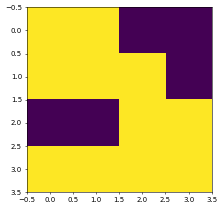

In [24]:
env.render()

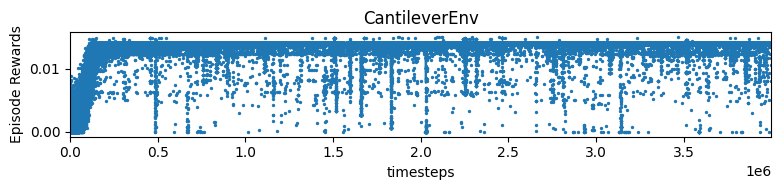

In [25]:
results_plotter.plot_results([log_dir], ts, results_plotter.X_TIMESTEPS, "CantileverEnv")

In [26]:
obs=env.reset()[0]

In [27]:
# Load the agent
model_best = PPO.load(log_dir + "best_model.zip",env=env)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.render_mode to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.render_mode` for environment variables or `env.get_wrapper_attr('render_mode')` that will search the reminding wrappers.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/stable_baselines3/common/vec_env/base_vec_env.py:77: UserWarning: The `render_mode` attribute is not defined in your environment. It will be set to None.
  warnings.warn("The `render_mode` attribute is not defined in your environment. It will be set to None.")


In [28]:
i=0
while i<1000:
    action, _states = model_best.predict(obs)
    
    obs, rewards, dones, _,info = env.step(int(action))
    print(env.tmp, env.const)
    if dones:
        break
    i+=1

227126606.56755757 0.06259375
97812645.3293964 0.12508750000000002
3005.1455196576094 0.18758125000000003
461.98142088277234 0.25007500000000005
256.34955241730756 0.31256875000000006
149.0810275655667 0.3750625000000001
73.62009379479721 0.43755625000000004
50.44729700783242 0.5000500000000001
37.75741922860529 0.5625437500000001
29.098324511900152 0.6250375000000001
22.225116330239118 0.6875312500000001
22.225116330239118 0.6875312500000001
22.225116330239118 0.6875312500000001
22.225116330239118 0.6875312500000001
22.225116330239118 0.6875312500000001
22.225116330239118 0.6875312500000001
22.225116330239118 0.6875312500000001


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.tmp to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.tmp` for environment variables or `env.get_wrapper_attr('tmp')` that will search the reminding wrappers.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.const to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.const` for environment variables or `env.get_wrapper_attr('const')` that will search the reminding wrappers.
  logger.warn(


In [29]:
i

16


Final Cantilever beam design:


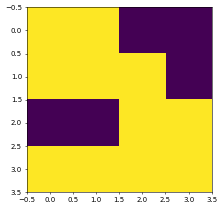

In [30]:
env.render()

In [31]:
# TODO - https://www.sciencedirect.com/science/article/pii/S0264127522002933

# 6 by 6 grid
# different reward 3 
# training ~1.5 hr

# illegal moves reward = -1, terminate ? 

# CNN
# randomize loads 
# utilize symmetry
# reward at the end of episode
# action - remove elements not add 
# refinement 6x6 -> 12x12
# load two elements in inference - test generalizability
# input stress field instead of density field 
# test different RL algorithms 